In [1]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml

In [2]:
sdss = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinespecobj.csv',
                   usecols=["CaHK_0_p","g_chp_psf_p","r_chp_psf_p","i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
                            "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","CLASS_s"])

In [3]:
sdss = sdss.loc[(sdss["g_chp_psf_p"] < 1e19) & (sdss["r_chp_psf_p"] < 1e19) & (sdss["i_chp_psf_p"] < 1e19) & \
                        (sdss["z_chp_psf_p"] < 1e19) & (sdss["y_chp_psf_p"] < 1e19) & (sdss["MAG_AUTO_p"] < 95) & \
                        (np.isnan(sdss["phot_g_mean_mag_1_p"]) == False) & (np.isnan(sdss["phot_bp_mean_mag_1_p"]) == False) & \
                        (np.isnan(sdss["phot_rp_mean_mag_1_p"]) == False)]

In [4]:
sdss = sdss.replace({'CLASS_s':np.nan}, -1)
sdss = sdss.replace({'CLASS_s':'STAR'}, 1)
sdss = sdss.replace({'CLASS_s':'GALAXY'}, 2)
sdss = sdss.replace({'CLASS_s':'QSO'}, 3)

In [5]:
df_joined = vaex.from_pandas(pd.DataFrame({'G_gaia': sdss["CaHK_0_p"]-sdss['phot_g_mean_mag_1_p'],
                   'B_gaia': sdss["CaHK_0_p"]-sdss['phot_bp_mean_mag_1_p'],
                   'R_gaia': sdss["CaHK_0_p"]-sdss['phot_rp_mean_mag_1_p'],
                   'G_pan': sdss["CaHK_0_p"]-sdss['g_chp_psf_p'],
                   'R_pan': sdss["CaHK_0_p"]-sdss['r_chp_psf_p'],
                   'I_pan': sdss["CaHK_0_p"]-sdss['i_chp_psf_p'],
                   'Z_pan': sdss["CaHK_0_p"]-sdss['z_chp_psf_p'],
                   'Y_pan': sdss["CaHK_0_p"]-sdss['y_chp_psf_p'],
                   'AUTO_cfis': sdss["CaHK_0_p"]-sdss['MAG_AUTO_p']},
                   index=np.arange(0,len(sdss))))
df2 = pd.DataFrame({'Class': sdss['CLASS_s']}, index = np.arange(0,len(sdss)))

In [6]:
df2.Class.value_counts()

-1.0    3555850
 1.0      69473
 3.0      62516
 2.0      58534
Name: Class, dtype: int64

In [7]:
print(df_joined.shape)
df_joined = df_joined.dropna()
print(df_joined.shape)
print(df2.shape)
df2 = df2.dropna()
print(df2.shape)

(3925373, 9)
(3746373, 9)
(3925373, 1)
(3746373, 1)


In [8]:
scaled_star_data = StandardScaler().fit_transform(df_joined)

In [9]:
%%time
fitter = umap.UMAP(verbose=True).fit(scaled_star_data, y=df2['Class'])
embedding = fitter.embedding_

UMAP( verbose=True)
Mon Feb 28 03:51:07 2022 Construct fuzzy simplicial set
Mon Feb 28 03:51:08 2022 Finding Nearest Neighbors
Mon Feb 28 03:51:08 2022 Building RP forest with 64 trees
Mon Feb 28 03:51:50 2022 NN descent for 22 iterations
	 1  /  22
	 2  /  22
	Stopping threshold met -- exiting after 2 iterations
Mon Feb 28 03:56:56 2022 Finished Nearest Neighbor Search
Mon Feb 28 03:57:54 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Mon Feb 28 04:56:22 2022 Finished embedding
CPU times: user 14h 40min 30s, sys: 44min 19s, total: 15h 24min 50s
Wall time: 1h 5min 16s


In [10]:
df2cmap = df2.replace(-1,0)

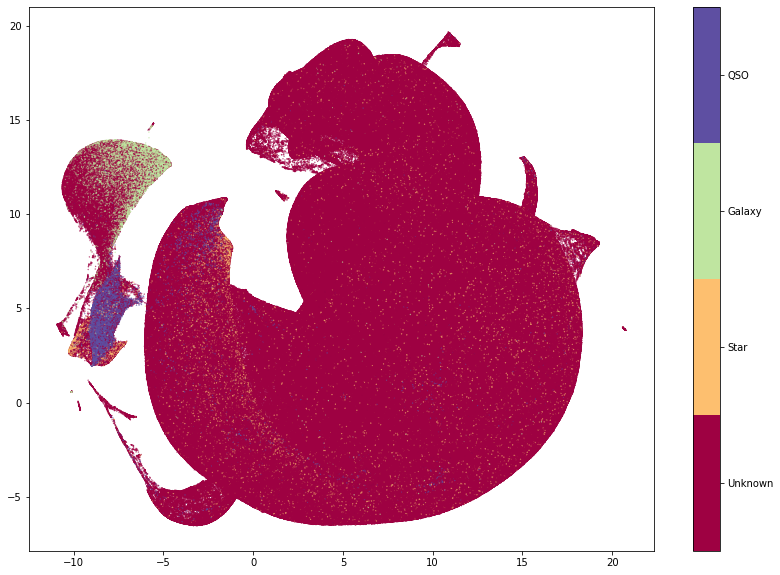

In [11]:
fig, ax = plt.subplots(1, figsize=(14, 10))
cax = ax.scatter(*embedding.T, s=0.1, c=df2cmap['Class'], cmap='Spectral', alpha=1.0)
# ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, boundaries=np.arange(5)-0.5, ticks=[0, 1, 2, 3]);
cbar.ax.set_yticklabels(['Unknown','Star','Galaxy','QSO']);
# ax.set_title("Celestial Objects in Pristine, Embedded via UMAP using Partial Labels")
plt.savefig('/arc/home/aydanmckay/semipristinecolouredbyspecobjsclass.svg')

In [12]:
mask = df2cmap['Class'] != 0

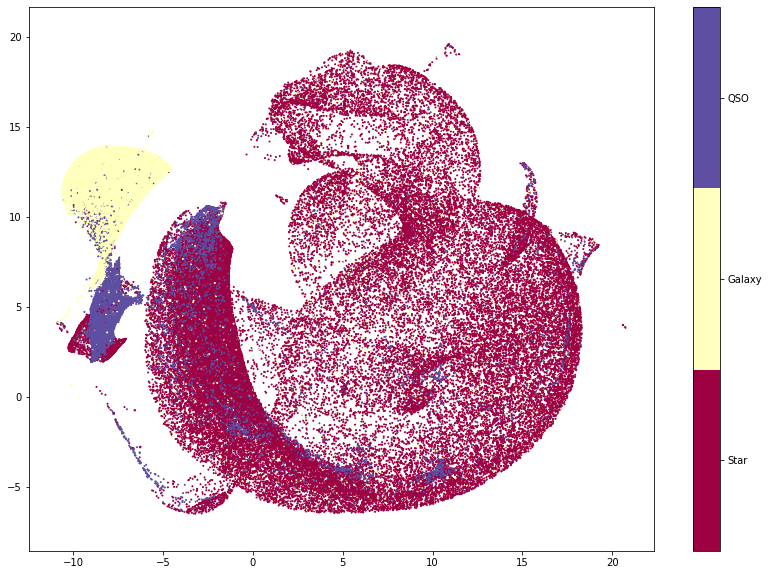

In [13]:
# fig, ax = plt.subplots(figsize=(12,12));
fig, ax = plt.subplots(1, figsize=(14, 10))
cax = ax.scatter(embedding[:,0][mask],embedding[:,1][mask], s=1, c=df2cmap['Class'][mask], cmap='Spectral', alpha=1.0);
ax.set_aspect('equal', 'datalim');
cbar = fig.colorbar(cax, boundaries=np.arange(1,5)-0.5, ticks=[1, 2, 3]);
cbar.ax.set_yticklabels(['Star','Galaxy','QSO']);
# ax.set_title("Celestial Objects in Pristine, Embedded via UMAP using Partial Labels");
plt.savefig('/arc/home/aydanmckay/semipristinecolouredbyspecobjsclassnounknowns.svg')